# Imports and datafetching

In [2]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/My Drive/deeplearning/training_dataset'

Mounted at /content/drive


## Dependencies

In [3]:
! pip install segmentation-models > /dev/null 2>&1

import os
import numpy as np
import matplotlib.pyplot as plt
import random

from PIL import Image,  ImageOps
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


#Check the version of TensorFlow you are using. Should be > 2.14.0
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Segmentation Models: using `tf.keras` framework.
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preprocessing

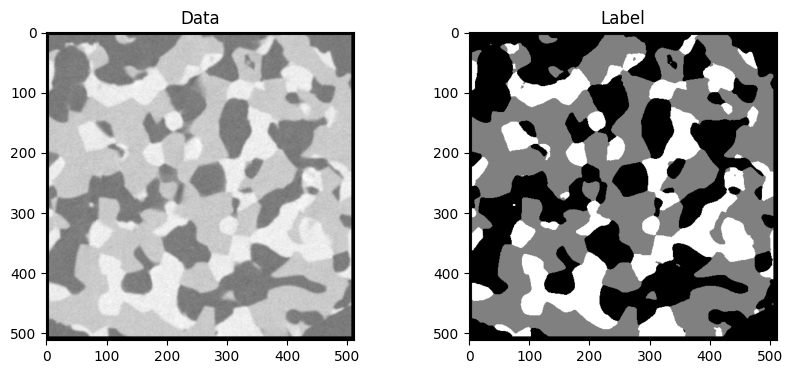

In [4]:
data_dir = os.path.join(drive_path, 'data')
labels_dir = os.path.join(drive_path, 'labels')


# Function for loading all the images in the dataset, and adding padding so that they all match the desired input size of 512x512
def load_and_resize_images(directory, target_size=(512, 512)):
    images = []
    file_names = os.listdir(directory)
    # Sorts to make sure the labels match the input images
    file_names.sort()
    for file_name in file_names:
        img_path = os.path.join(directory, file_name)
        img = Image.open(img_path)

        # Calculate padding
        old_size = img.size
        delta_w = target_size[0] - old_size[0]
        delta_h = target_size[1] - old_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

        # Apply padding
        new_img = ImageOps.expand(img, padding)

        # Convert to array
        new_img = image.img_to_array(new_img)
        images.append(new_img)

    # Returns the array of padded images from the dataset
    return np.array(images)

# Load and resize the images and labels
data_images = load_and_resize_images(data_dir)
label_images = load_and_resize_images(labels_dir)

# Checks that the images and labels has been correctly loaded
def display_sample(data, labels, index):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(data[index].squeeze(), cmap='gray')
    plt.title('Data')
    plt.subplot(1, 2, 2)
    plt.imshow(labels[index].squeeze(), cmap='gray')
    plt.title('Label')
    plt.show()

# Display a random image and its label
display_sample(data_images, label_images, random.randint(1, len(data_images)))

## Splitting the dataset into training and validation set
We want to test out training with only one image

In [6]:
random.seed(42)

# Randomly select 1 example for training and 500 for validation
# First, generate random unique indices
indices = np.random.permutation(len(data_images))
train_indices = indices[:1]  # First index for training
val_indices = indices[1:500]  # Next 500 indices for validation

# Split the data
data_train = data_images[train_indices]
labels_train = train_labels_categorical[train_indices]

data_val = data_images[val_indices]
labels_val = train_labels_categorical[val_indices]


normal_datagen = ImageDataGenerator()

## Implementing augmentation
We implement augmentation by flipping each image 4 times, and therefore expanding our trainingset by x4

In [7]:
import numpy as np

def augment_images_and_labels(images, labels):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        # Original image and label
        augmented_images.append(image)
        augmented_labels.append(label)

        # Rotate 90 degrees
        rotated_90_image = np.rot90(image)
        rotated_90_label = np.rot90(label)
        augmented_images.append(rotated_90_image)
        augmented_labels.append(rotated_90_label)

        # Rotate 180 degrees
        rotated_180_image = np.rot90(rotated_90_image)
        rotated_180_label = np.rot90(rotated_90_label)
        augmented_images.append(rotated_180_image)
        augmented_labels.append(rotated_180_label)

        # Rotate 270 degrees
        rotated_270_image = np.rot90(rotated_180_image)
        rotated_270_label = np.rot90(rotated_180_label)
        augmented_images.append(rotated_270_image)
        augmented_labels.append(rotated_270_label)

    return np.array(augmented_images), np.array(augmented_labels)

# Assuming data_train and labels_train are your original training datasets
augmented_data_train, augmented_labels_train = augment_images_and_labels(data_train, labels_train)


## Accuracy table

## Display and predict a image

Using the four different approaches, we want to visualize the original image, true label, and predicted label

In [8]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import legacy

# Preprocess the data for the resnet34-model (model2)
preprocess = get_preprocessing('resnet34')
pre_data_train = preprocess(data_train)
pre_data_val = preprocess(data_val)

# Parameters for both models
optimizer = legacy.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']



validation_generator2 = normal_datagen.flow(pre_data_val, labels_val, batch_size=1)

# Custom callback function that only calculates validation accuracy each n-th iteration, in order to save time
class NthEpochEvaluation(Callback):
    def __init__(self, val_generator, n=10):
        super().__init__()
        self.val_generator = val_generator
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            val_loss, val_acc = self.model.evaluate(self.val_generator, verbose=0)
            logs['val_loss'] = val_loss
            logs['val_accuracy'] = val_acc

# Create an instance of the custom callback, set n to the desired interval
# We do this to make the training faster
nth_epoch_eval2 = NthEpochEvaluation(validation_generator2, n=25)

model2 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
pre_augmented_data_train = preprocess(augmented_data_train)
train_aug = normal_datagen.flow(pre_augmented_data_train, augmented_labels_train, batch_size=1)
resnet_training_with_augmentation = model2.fit(train_aug, epochs=500, batch_size=1, callbacks=[nth_epoch_eval2])

Epoch 1/500
4/4 [==============================] - 26s 91ms/step - loss: 1.3035 - accuracy: 0.4009
Epoch 2/500
3/4 [=====================>........] - ETA: 0s - loss: 0.9272 - accuracy: 0.6479

4/4 [==============================] - 0s 95ms/step - loss: 0.9021 - accuracy: 0.6663
Epoch 3/500
4/4 [==============================] - 0s 84ms/step - loss: 0.7072 - accuracy: 0.7851
Epoch 4/500
4/4 [==============================] - 0s 86ms/step - loss: 0.5819 - accuracy: 0.8461
Epoch 5/500
4/4 [==============================] - 0s 88ms/step - loss: 0.4951 - accuracy: 0.8824
Epoch 6/500
4/4 [==============================] - 0s 85ms/step - loss: 0.4260 - accuracy: 0.9073
Epoch 7/500
4/4 [==============================] - 0s 85ms/step - loss: 0.3730 - accuracy: 0.9240
Epoch 8/500
4/4 [==============================] - 0s 88ms/step - loss: 0.3325 - accuracy: 0.9354
Epoch 9/500
4/4 [==============================] - 0s 90ms/step - loss: 0.3000 - accuracy: 0.9450
Epoch 10/500
4/4 [==============================] - 0s 93ms/step - loss: 0.2741 - accuracy: 0.9528
Epoch 11/500
4/4 [==============================] - 0s 93ms/step - loss: 0.2529 - accuracy: 0.9589
Epoch 12/500
4/4 [============

In [9]:
# Code for noise - use model2 that was initialized over, or just train the model again:

# model2 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')
# model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# pre_augmented_data_train = preprocess(augmented_data_train)
# print(len(pre_augmented_data_train)) # should be 4 (1 image rotated 4 times)
# train_aug = normal_datagen.flow(pre_augmented_data_train, augmented_labels_train, batch_size=1)
# resnet_training_with_augmentation = model2.fit(train_aug, epochs=500, batch_size=1, callbacks=[nth_epoch_eval2])

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(data_images, label_images, test_size=0.1)
test_labels_class = map_grayscale_to_class(test_labels)
test_labels_categorical = to_categorical(test_labels_class, num_classes=3)
test_images = test_data

##Different noise functions

In [11]:
def add_gaussian_noise(image, mean=0, variance=0.1):
    std = variance ** 0.5
    gaussian_noise = np.random.normal(mean, std, image.shape)

    # Scaling the noise
    max_val = np.max(image)
    gaussian_noise_scaled = gaussian_noise * (max_val * 0.1)  # Scale by 10% of the max value

    noisy_image = image + gaussian_noise_scaled
    return noisy_image.astype(image.dtype)

In [12]:
def add_salt_pepper_noise(image, density=0.01):
    s_vs_p = 0.5
    noisy_image = np.copy(image)
    # Salt mode
    num_salt = np.ceil(density * image.size * s_vs_p).astype(int)
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]  # Only for height and width
    for x, y in zip(*coords):
        noisy_image[x, y] = 255  # Add salt
    # Pepper mode
    num_pepper = np.ceil(density * image.size * (1. - s_vs_p)).astype(int)
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]  # Only for height and width
    for x, y in zip(*coords):
        noisy_image[x, y] = 0  # Add pepper
    return noisy_image

In [13]:
def add_speckle_noise(image, variance=0.04):
    # Generating speckle noise
    noise = np.random.normal(1, variance**0.5, image.shape)

    # Applying the noise multiplicatively
    noisy_image = image * noise

    # Return the noisy image in the same data type as the original image
    return noisy_image.astype(image.dtype)

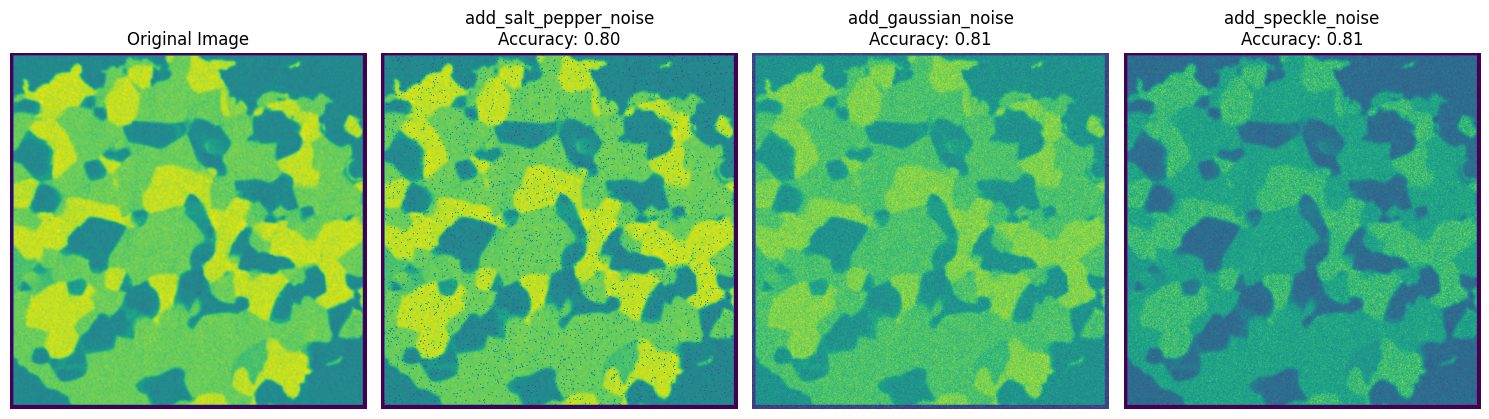

In [21]:
#Plotting functions
def plot_noisy_images(model, original_image, noise_functions, noise_params, label_categorical):
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, len(noise_functions) + 1, 1)
    plt.imshow(np.squeeze(original_image[0]))  # Squeeze only the first dimension (batch size)
    plt.title('Original Image')
    plt.axis('off')

    # Generate and plot noisy images
    for i, (noise_function, params) in enumerate(zip(noise_functions, noise_params), 1):
        # Add noise to the original image
        noisy_image = noise_function(original_image[0], **params)
        noisy_image_expanded = np.expand_dims(noisy_image, axis=0)  # Add the batch dimension

        # Predict and evaluate
        _, accuracy = model.evaluate(noisy_image_expanded, label_categorical, verbose=0)

        plt.subplot(1, len(noise_functions) + 1, i + 1)
        plt.imshow(np.squeeze(noisy_image)) #SJEKK FARGER
        plt.title(f'{noise_function.__name__}\nAccuracy: {accuracy:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a random image from test data
index_to_visualize = np.random.randint(0, test_data.shape[0])
original_image = test_data[index_to_visualize]
label_categorical = test_labels_categorical[index_to_visualize]

# Expand dimensions to add the batch size of 1
original_image_expanded = np.expand_dims(original_image, axis=0)
label_categorical_expanded = np.expand_dims(label_categorical, axis=0)

# Define your noise functions and parameters for each
noise_functions = [add_salt_pepper_noise, add_gaussian_noise, add_speckle_noise]
noise_params = [
    {'density': 0.014},  # Example parameters for salt and pepper noise
    {'mean': 0, 'variance': 0.6},  # Example parameters for Gaussian noise
    {'variance': 0.01}  # Example parameters for Speckle noise
]

original_image_expanded = np.expand_dims(original_image, axis=0)  # Add the batch dimension
label_categorical_expanded = np.expand_dims(label_categorical, axis=0)

# Plot the images
plot_noisy_images(model2, original_image_expanded, noise_functions, noise_params, label_categorical_expanded)

##Salt and pepper noise

In [ ]:
def add_salt_and_pepper_noise_to_images(images, **kwargs):
    noisy_images = []
    for img in images:
          noisy_img = add_salt_pepper_noise(img, density=kwargs.get('density', 0.01))  # Use the density parameter
          noisy_images.append(noisy_img)
    return np.array(noisy_images)

def evaluate_model_with_salt_pepper_noise(model, test_data, test_labels, densities):
    accuracies = [model.evaluate(test_data, test_labels, verbose=0)[1]]  # Start with original accuracy
    for density in densities[1:]:  # Skip the first as it's for no noise
        noisy_test_data = add_salt_and_pepper_noise_to_images(test_data, density=density)
        accuracy = model.evaluate(noisy_test_data, test_labels, verbose=0)[1]
        accuracies.append(accuracy)
    return accuracies

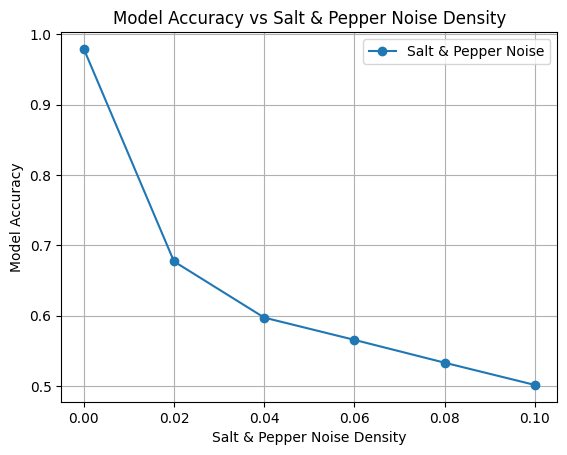

In [ ]:
# Define a range of densities for salt-and-pepper noise
densities = np.linspace(0.0, 0.05, 6)  # Example: from 0.0 to 0.1 in steps of 0.01

# Evaluate the model
sp_accuracies = evaluate_model_with_salt_pepper_noise(model2, test_data, test_labels_categorical, densities)

# Plot the results
plt.plot(densities, sp_accuracies, label='Salt & Pepper Noise', marker='o')
plt.xlabel('Salt & Pepper Noise Density')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs Salt & Pepper Noise Density')
plt.legend()
plt.grid(True)
plt.show()

##Spekcle noise

In [ ]:
def add_specle_noise_to_images(images, **kwargs):
    noisy_images = []
    for img in images:
          noisy_img = add_speckle_noise(img, variance=kwargs.get('variance', 0.04))
          noisy_images.append(noisy_img)
    return np.array(noisy_images)

def evaluate_model_with_speckle_noise(model, test_data, test_labels, variances):
    accuracies = [model.evaluate(test_data, test_labels, verbose=0)[1]]  # Start with original accuracy
    for variance in variances[1:]:
        noisy_test_data = add_specle_noise_to_images(test_data, variance=variance)
        accuracy = model.evaluate(noisy_test_data, test_labels, verbose=0)[1]
        accuracies.append(accuracy)
    return accuracies

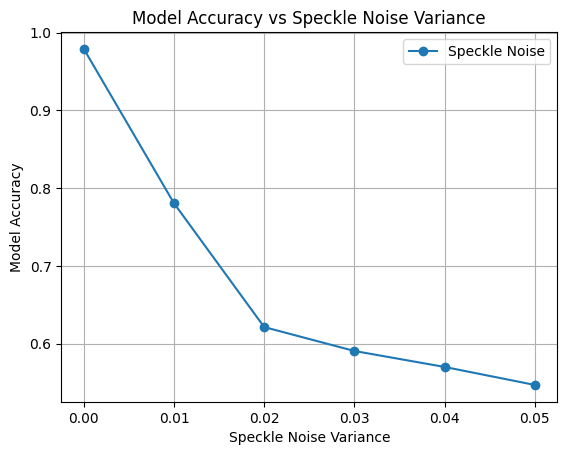

In [ ]:
# Define a range of variances for speckle noise
speckle_variances = np.linspace(0.0, 0.05, 6)  # Example: from 0.0 to 0.1 in steps of 0.01

# Evaluate the model
speckle_accuracies = evaluate_model_with_speckle_noise(model2, test_data, test_labels_categorical, speckle_variances)

# Plot the results
plt.plot(speckle_variances, speckle_accuracies, label='Speckle Noise', marker='o')
plt.xlabel('Speckle Noise Variance')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs Speckle Noise Variance')
plt.legend()
plt.grid(True)
plt.show()


##Gaussian noise

In [ ]:
def add_gaussian_noise_to_images(images, **kwargs):
  noisy_images = []
  for img in images:
    noisy_img = add_gaussian_noise(img, variance=kwargs.get('variance', 0.1))
    noisy_images.append(noisy_img)
  return np.array(noisy_images)

def evaluate_model_with_gaussian_noise(model, test_data, test_labels, variances):
  accuracies = [model.evaluate(test_data, test_labels, verbose=0)[1]]
  for variance in variances[1:]:
    noisy_test_data = add_gaussian_noise_to_images(test_data, variance=variance)
    accuracy = model.evaluate(noisy_test_data, test_labels, verbose=0)[1]
    accuracies.append(accuracy)
  return accuracies

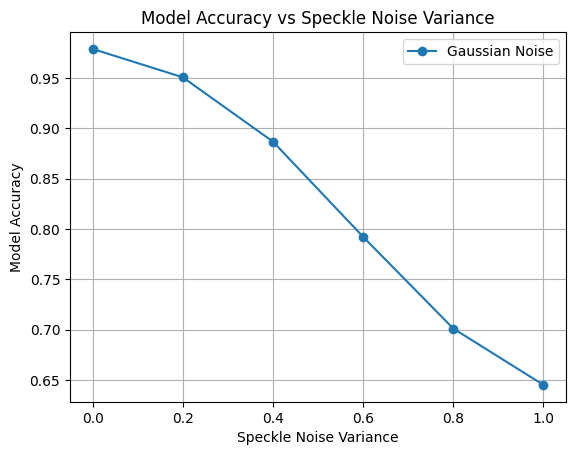

In [ ]:
# Define a range of variances for speckle noise
gaussian_variances = np.linspace(0.0, 1, 6)  # Example: from 0.0 to 0.1 in steps of 0.01

# Evaluate the model
gaussian_accuracies = evaluate_model_with_gaussian_noise(model2, test_data, test_labels_categorical, gaussian_variances)

# Plot the results
plt.plot(gaussian_variances, gaussian_accuracies, label='Gaussian Noise', marker='o')
plt.xlabel('Speckle Noise Variance')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs Speckle Noise Variance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Combine the data into a list of tuples
data = []

# Salt and Pepper Noise
for density, accuracy in zip(densities, sp_accuracies):
    data.append(('Salt and Pepper', density, accuracy))

# Speckle Noise
for variance, accuracy in zip(speckle_variances, speckle_accuracies):
    data.append(('Speckle', variance, accuracy))

# Gaussian Noise
for variance, accuracy in zip(gaussian_variances, gaussian_accuracies):
    data.append(('Gaussian', variance, accuracy))

# Create DataFrame
df = pd.DataFrame(data, columns=['Noise Type', 'Parameter', 'Accuracy'])


         Noise Type  Parameter  Accuracy
0   Salt and Pepper       0.00  0.979101
1   Salt and Pepper       0.02  0.677168
2   Salt and Pepper       0.04  0.597408
3   Salt and Pepper       0.06  0.565782
4   Salt and Pepper       0.08  0.533360
5   Salt and Pepper       0.10  0.501757
6           Speckle       0.00  0.979101
7           Speckle       0.01  0.780579
8           Speckle       0.02  0.621361
9           Speckle       0.03  0.590600
10          Speckle       0.04  0.570065
11          Speckle       0.05  0.546941
12         Gaussian       0.00  0.979101
13         Gaussian       0.20  0.950907
14         Gaussian       0.40  0.886937
15         Gaussian       0.60  0.792263
16         Gaussian       0.80  0.701037
17         Gaussian       1.00  0.644984


In [ ]:
df

,Noise Type,Parameter,Accuracy
0,Salt and Pepper,0.00,0.979101
1,Salt and Pepper,0.02,0.677168
2,Salt and Pepper,0.04,0.597408
3,Salt and Pepper,0.06,0.565782
4,Salt and Pepper,0.08,0.533360
5,Salt and Pepper,0.10,0.501757
6,Speckle,0.00,0.979101
7,Speckle,0.01,0.780579
8,Speckle,0.02,0.621361
9,Speckle,0.03,0.590600


In [ ]:
import pandas as pd

# Create DataFrame for Salt and Pepper Noise
sp_data = [('Salt and Pepper', density, accuracy) for density, accuracy in zip(densities, sp_accuracies)]
df_salt_pepper = pd.DataFrame(sp_data, columns=['Noise Type', 'Parameter', 'Accuracy'])

# Create DataFrame for Speckle Noise
speckle_data = [('Speckle', variance, accuracy) for variance, accuracy in zip(speckle_variances, speckle_accuracies)]
df_speckle = pd.DataFrame(speckle_data, columns=['Noise Type', 'Parameter', 'Accuracy'])

# Create DataFrame for Gaussian Noise
gaussian_data = [('Gaussian', variance, accuracy) for variance, accuracy in zip(gaussian_variances, gaussian_accuracies)]
df_gaussian = pd.DataFrame(gaussian_data, columns=['Noise Type', 'Parameter', 'Accuracy'])

# Display DataFrames
print("Salt and Pepper Noise:")
print(df_salt_pepper)
print("\nSpeckle Noise:")
print(df_speckle)
print("\nGaussian Noise:")
print(df_gaussian)


Salt and Pepper Noise:
        Noise Type  Parameter  Accuracy
0  Salt and Pepper       0.00  0.979101
1  Salt and Pepper       0.02  0.677168
2  Salt and Pepper       0.04  0.597408
3  Salt and Pepper       0.06  0.565782
4  Salt and Pepper       0.08  0.533360
5  Salt and Pepper       0.10  0.501757

Speckle Noise:
  Noise Type  Parameter  Accuracy
0    Speckle       0.00  0.979101
1    Speckle       0.01  0.780579
2    Speckle       0.02  0.621361
3    Speckle       0.03  0.590600
4    Speckle       0.04  0.570065
5    Speckle       0.05  0.546941

Gaussian Noise:
  Noise Type  Parameter  Accuracy
0   Gaussian        0.0  0.979101
1   Gaussian        0.2  0.950907
2   Gaussian        0.4  0.886937
3   Gaussian        0.6  0.792263
4   Gaussian        0.8  0.701037
5   Gaussian        1.0  0.644984


In [ ]:
df_salt_pepper

,Noise Type,Parameter,Accuracy
0,Salt and Pepper,0.00,0.979101
1,Salt and Pepper,0.02,0.677168
2,Salt and Pepper,0.04,0.597408
3,Salt and Pepper,0.06,0.565782
4,Salt and Pepper,0.08,0.533360
5,Salt and Pepper,0.10,0.501757


In [ ]:
df_speckle

,Noise Type,Parameter,Accuracy
0,Speckle,0.00,0.979101
1,Speckle,0.01,0.780579
2,Speckle,0.02,0.621361
3,Speckle,0.03,0.590600
4,Speckle,0.04,0.570065
5,Speckle,0.05,0.546941


In [ ]:
df_gaussian

,Noise Type,Parameter,Accuracy
0,Gaussian,0.0,0.979101
1,Gaussian,0.2,0.950907
2,Gaussian,0.4,0.886937
3,Gaussian,0.6,0.792263
4,Gaussian,0.8,0.701037
5,Gaussian,1.0,0.644984
